In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local[*]")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### IMPORTS ###
from pyspark.sql.functions import sum,col,split,expr,concat,concat_ws,lit,to_date,count,avg,when
from pyspark.sql.types import FloatType, TimestampType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from matplotlib.ticker import MaxNLocator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window
import seaborn as sns

In [ ]:
### CONFIG ###

#year_month={"2019":["10","11","12"], "2020":["01","02","03","04"]}
year_month={"2019":["10","11"]}
raw_data_files = [#"/content/drive/Shareddrives/FourYottaBytes_DA231o/2019-Nov.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2019-Oct.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2019_Dec.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Jan.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Feb.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Mar.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Apr.csv"]
output_parquet_save_path="/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/"

In [ ]:
#Sample parquet read for selected year and months
dfp=[]
for year, months in year_month.items():
  for month in months:
    path="/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified/date="+year+"-"+month+"*"
    print("Reading :"+path)
    df=spark.read.parquet(path)
    dfp.append(df)

total_df=dfp[0]
for i in range(1,len(dfp)):
  total_df=total_df.union(dfp[i])

Reading :/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified/date=2019-10*
Reading :/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified/date=2019-11*


In [ ]:
#do cache if the data size is not too large
total_df.cache()
total_df.count()

68650184

In [ ]:
total_df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
#w = (Window().partitionBy(col("user_id")).orderBy(col("event_date").cast('long')).rangeBetween(((-2)*60*60*24), ((-1)*60*60*24)))

In [ ]:
avg_total_daily_session_df=total_df.select("event_time","user_id","user_session").withColumn("event_date",to_date(col("event_time"))).drop("event_time").groupBy("event_date","user_id").agg(count("user_session").alias("daily_session_count")).select("user_id","daily_session_count").groupBy("user_id").agg(avg("daily_session_count").alias("avg_daily_session_count"),sum("daily_session_count").alias("total_session_count"))

In [ ]:
avg_total_daily_session_df.show(10,0)

+---------+-----------------------+-------------------+
|user_id  |avg_daily_session_count|total_session_count|
+---------+-----------------------+-------------------+
|519098537|2.0                    |2                  |
|515041778|11.090909090909092     |122                |
|547559830|5.166666666666667      |31                 |
|560087219|4.4                    |22                 |
|517198917|16.384615384615383     |426                |
|519181893|4.571428571428571      |32                 |
|530053826|4.5                    |9                  |
|550618224|6.5                    |39                 |
|562730764|2.0                    |2                  |
|513804685|5.0                    |50                 |
+---------+-----------------------+-------------------+
only showing top 10 rows



In [ ]:
purchase_df=total_df.filter(col("event_type")=="purchase").select("event_time","user_id","user_session").withColumn("event_date",to_date(col("event_time"))).drop("event_time").groupBy("event_date","user_id").agg(count("user_session").alias("daily_purchase_count")).select("user_id","daily_purchase_count").groupBy("user_id").agg(avg("daily_purchase_count").alias("avg_daily_purchase_count"),sum("daily_purchase_count").alias("total_purchase_count"))

In [ ]:
purchase_df.show(10,0)

+---------+------------------------+--------------------+
|user_id  |avg_daily_purchase_count|total_purchase_count|
+---------+------------------------+--------------------+
|557678114|1.8333333333333333      |22                  |
|512977906|1.0                     |1                   |
|556996610|1.0                     |1                   |
|536866041|2.3181818181818183      |51                  |
|544677919|1.3333333333333333      |4                   |
|516278856|1.0                     |6                   |
|512896481|1.0                     |5                   |
|549393227|1.0                     |1                   |
|532721146|1.4                     |7                   |
|519497399|4.076923076923077       |53                  |
+---------+------------------------+--------------------+
only showing top 10 rows



In [ ]:
view_df=total_df.filter(col("event_type")=="view").select("event_time","user_id","user_session").withColumn("event_date",to_date(col("event_time"))).drop("event_time").groupBy("event_date","user_id").agg(count("user_session").alias("daily_view_count")).select("user_id","daily_view_count").groupBy("user_id").agg(avg("daily_view_count").alias("avg_daily_view_count"),sum("daily_view_count").alias("total_view_count"))

In [ ]:
view_df.show(10,0)

+---------+--------------------+----------------+
|user_id  |avg_daily_view_count|total_view_count|
+---------+--------------------+----------------+
|519098537|2.0                 |2               |
|517198917|15.23076923076923   |396             |
|547559830|3.8333333333333335  |23              |
|515041778|9.363636363636363   |103             |
|560087219|4.4                 |22              |
|519181893|4.0                 |28              |
|530053826|4.5                 |9               |
|550618224|5.333333333333333   |32              |
|562730764|2.0                 |2               |
|513804685|5.0                 |50              |
+---------+--------------------+----------------+
only showing top 10 rows



In [ ]:
cart_df=total_df.filter(col("event_type")=="cart").select("event_time","user_id","user_session").withColumn("event_date",to_date(col("event_time"))).drop("event_time").groupBy("event_date","user_id").agg(count("user_session").alias("daily_cart_count")).select("user_id","daily_cart_count").groupBy("user_id").agg(avg("daily_cart_count").alias("avg_daily_cart_count"),sum("daily_cart_count").alias("total_cart_count"))

In [ ]:
cart_df.show(10,0)

+---------+--------------------+----------------+
|user_id  |avg_daily_cart_count|total_cart_count|
+---------+--------------------+----------------+
|517198917|3.0                 |24              |
|512977906|9.0                 |9               |
|545576624|4.0                 |4               |
|536866041|2.9047619047619047  |61              |
|544677919|1.5                 |3               |
|516278856|1.0                 |5               |
|512896481|1.25                |5               |
|532721146|2.4                 |12              |
|523618230|2.0                 |2               |
|517249410|1.5                 |3               |
+---------+--------------------+----------------+
only showing top 10 rows



In [ ]:
purchase_price_df=total_df.filter(col("event_type")=="purchase").select("event_time","user_id","price").withColumn("event_date",to_date(col("event_time"))).drop("event_time").groupBy("event_date","user_id").agg(sum("price").alias("daily_purchase_amount")).select("user_id","daily_purchase_amount").groupBy("user_id").agg(avg("daily_purchase_amount").alias("avg_daily_purchase_amount"),sum("daily_purchase_amount").alias("total_purchase_amount"))

In [ ]:
cart_price_df=total_df.filter(col("event_type")=="cart").select("event_time","user_id","price").withColumn("event_date",to_date(col("event_time"))).drop("event_time").groupBy("event_date","user_id").agg(sum("price").alias("daily_cart_amount")).select("user_id","daily_cart_amount").groupBy("user_id").agg(avg("daily_cart_amount").alias("avg_daily_cart_amount"),sum("daily_cart_amount").alias("total_cart_amount"))

In [ ]:
purchase_price_df.show()
cart_price_df.show()

+---------+-------------------------+---------------------+
|  user_id|avg_daily_purchase_amount|total_purchase_amount|
+---------+-------------------------+---------------------+
|557678114|        574.9541702270508|    6899.450042724609|
|512977906|        286.8599853515625|    286.8599853515625|
|556996610|        66.66999816894531|    66.66999816894531|
|536866041|        491.8490887555209|    10820.67995262146|
|544677919|        553.0633341471354|   1659.1900024414062|
|516278856|       1160.9033304850261|    6965.419982910156|
|512896481|       234.68999938964845|   1173.4499969482422|
|549393227|        41.70000076293945|    41.70000076293945|
|532721146|        270.3800018310547|   1351.9000091552734|
|519497399|       1639.2123025747446|    21309.75993347168|
|543175818|        708.1000099182129|   2832.4000396728516|
|523896546|       2195.8367309570312|    6587.510192871094|
|564166269|       484.34666697184247|   1453.0400009155273|
|567383054|        384.5400085449219|   

In [ ]:
user_df=total_df.select("user_id").distinct()

In [ ]:
stat_df=user_df.join(avg_total_daily_session_df.join(view_df,"user_id","left"),"user_id","left").join(purchase_df,"user_id","left").join(cart_df,"user_id","left").join(purchase_price_df,"user_id","left").join(cart_price_df,"user_id","left")

In [ ]:
stat_df.cache()
stat_df.show()
stat_df.count()

+---------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
|  user_id|avg_daily_session_count|total_session_count|avg_daily_view_count|total_view_count|avg_daily_purchase_count|total_purchase_count|avg_daily_cart_count|total_cart_count|avg_daily_purchase_amount|total_purchase_amount|avg_daily_cart_amount|total_cart_amount|
+---------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
|222317983|                    1.0|                  1|                 1.0|               1|                    null|                null|                null|            null|                     null

4167673

In [ ]:
#stat_df.write.parquet("/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/user_stats/")

In [ ]:
stat_df.select([count(when(col(c).isNotNull(), c)).alias(c) for c in stat_df.columns]).show()

+-------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
|user_id|avg_daily_session_count|total_session_count|avg_daily_view_count|total_view_count|avg_daily_purchase_count|total_purchase_count|avg_daily_cart_count|total_cart_count|avg_daily_purchase_amount|total_purchase_amount|avg_daily_cart_amount|total_cart_amount|
+-------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
|4167673|                4167673|            4167673|             4167111|         4167111|                  533572|              533572|              833545|          833545|                   533572|       

In [ ]:
stat_df.filter(col("total_purchase_amount").isNotNull()).select([count(when(col(c).isNotNull(), c)).alias(c) for c in stat_df.columns]).show()

+-------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
|user_id|avg_daily_session_count|total_session_count|avg_daily_view_count|total_view_count|avg_daily_purchase_count|total_purchase_count|avg_daily_cart_count|total_cart_count|avg_daily_purchase_amount|total_purchase_amount|avg_daily_cart_amount|total_cart_amount|
+-------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
| 533572|                 533572|             533572|              533268|          533268|                  533572|              533572|              446760|          446760|                   533572|       

In [ ]:
stat_df.filter(col("total_purchase_amount").isNotNull()).fillna(0, subset=None).select([count(when(col(c).isNotNull(), c)).alias(c) for c in stat_df.columns]).show()

+-------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
|user_id|avg_daily_session_count|total_session_count|avg_daily_view_count|total_view_count|avg_daily_purchase_count|total_purchase_count|avg_daily_cart_count|total_cart_count|avg_daily_purchase_amount|total_purchase_amount|avg_daily_cart_amount|total_cart_amount|
+-------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+
| 533572|                 533572|             533572|              533572|          533572|                  533572|              533572|              533572|          533572|                   533572|       

In [ ]:
purchased_user_stats=stat_df.filter(col("total_purchase_amount").isNotNull()).fillna(0, subset=None)

In [ ]:
p_col=purchased_user_stats.columns
p_col.remove("user_id")
print(p_col)

['avg_daily_session_count', 'total_session_count', 'avg_daily_view_count', 'total_view_count', 'avg_daily_purchase_count', 'total_purchase_count', 'avg_daily_cart_count', 'total_cart_count', 'avg_daily_purchase_amount', 'total_purchase_amount', 'avg_daily_cart_amount', 'total_cart_amount']


In [ ]:
assemble=VectorAssembler(inputCols=p_col, outputCol='features')
assembled_data=assemble.transform(purchased_user_stats)
assembled_data.show(2,False)

+---------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+------------------------------------------------------------------------------------------------------------+
|user_id  |avg_daily_session_count|total_session_count|avg_daily_view_count|total_view_count|avg_daily_purchase_count|total_purchase_count|avg_daily_cart_count|total_cart_count|avg_daily_purchase_amount|total_purchase_amount|avg_daily_cart_amount|total_cart_amount|features                                                                                                    |
+---------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+---

In [ ]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2,False)

+---------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id  |avg_daily_session_count|total_session_count|avg_daily_view_count|total_view_count|avg_daily_purchase_count|total_purchase_count|avg_daily_cart_count|total_cart_count|avg_daily_purchase_amount|total_purchase_amount|avg_daily_cart_amount|total_cart_amount|features                                                                                                    |standardized        

In [ ]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', metricName='silhouette', distanceMeasure='squaredEuclidean')

In [ ]:
for i in range(10,20):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.4181776468221774
Silhouette Score: 0.4639111709195424
Silhouette Score: 0.4761689415467434
Silhouette Score: 0.4274870730437462
Silhouette Score: 0.4245768360715092
Silhouette Score: 0.41179815127887637
Silhouette Score: 0.4213676071244504
Silhouette Score: 0.35732302462050686
Silhouette Score: 0.3887556127434479
Silhouette Score: 0.35285041985917187


Text(0, 0.5, 'cost')

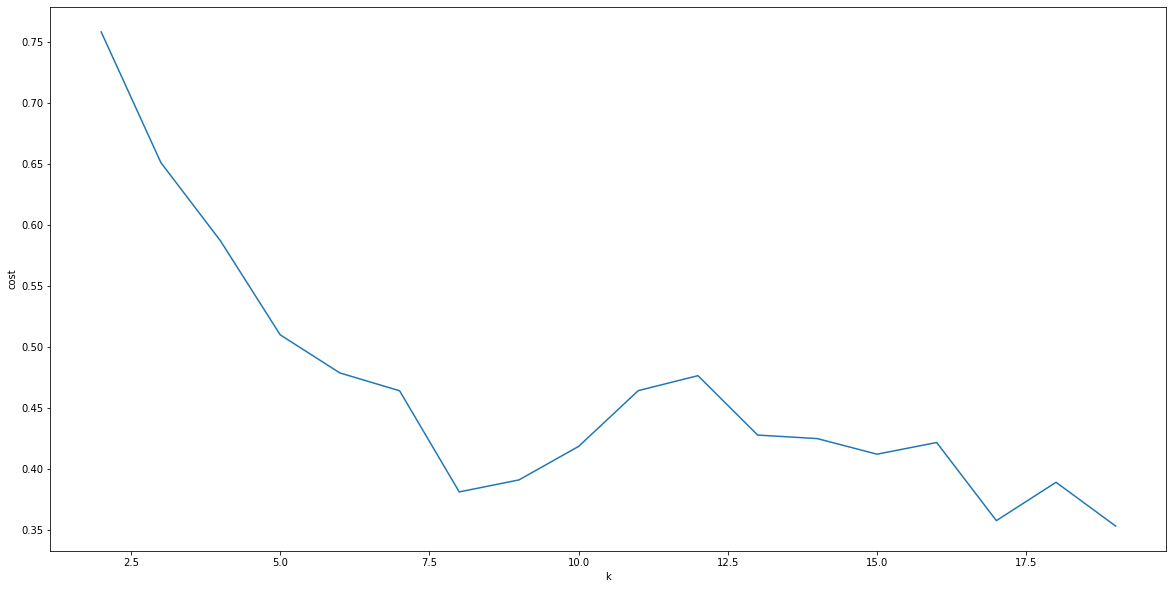

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(20,10))
ax.plot(range(2,20),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

In [ ]:
KMeans_algo=KMeans(featuresCol='standardized', k=5)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output=KMeans_fit.transform(data_scale_output)

In [ ]:
output.show(2,0)

+---------+-----------------------+-------------------+--------------------+----------------+------------------------+--------------------+--------------------+----------------+-------------------------+---------------------+---------------------+-----------------+------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|user_id  |avg_daily_session_count|total_session_count|avg_daily_view_count|total_view_count|avg_daily_purchase_count|total_purchase_count|avg_daily_cart_count|total_cart_count|avg_daily_purchase_amount|total_purchase_amount|avg_daily_cart_amount|total_cart_amount|features                                                                                                    |standardi

In [ ]:
output.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         3|
|         4|
|         2|
|         0|
+----------+



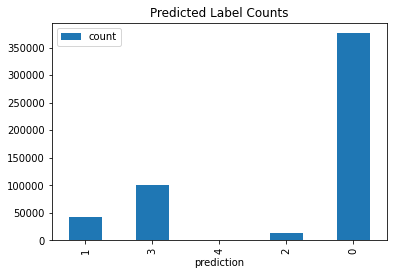

In [ ]:
output.groupBy("prediction").count().toPandas().plot.bar(x='prediction', y='count',title="Predicted Label Counts")

In [ ]:
output=spark.read.parquet("/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/clustering_result")

In [ ]:
op_df=output.toPandas()

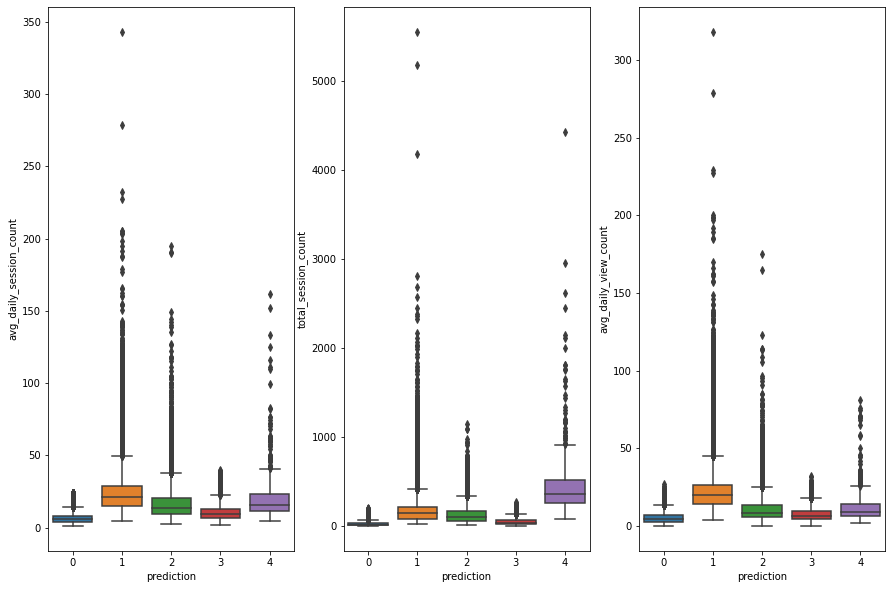

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sns.boxplot(x='prediction', y='avg_daily_session_count', data=op_df, ax=ax[0])
sns.boxplot(x='prediction', y='total_session_count', data=op_df, ax=ax[1])
sns.boxplot(x='prediction', y='avg_daily_view_count', data=op_df, ax=ax[2])

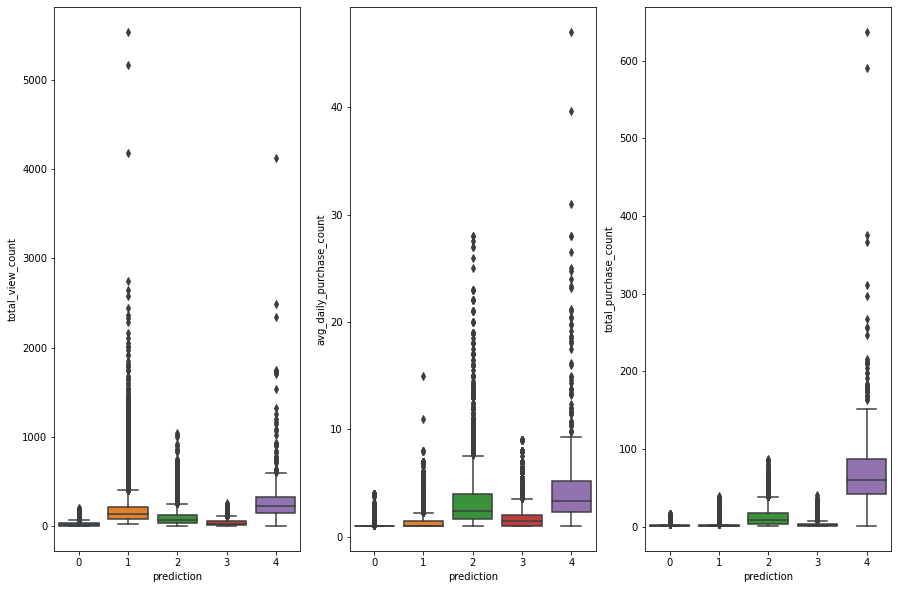

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sns.boxplot(x='prediction', y='total_view_count', data=op_df, ax=ax[0])
sns.boxplot(x='prediction', y='avg_daily_purchase_count', data=op_df, ax=ax[1])
sns.boxplot(x='prediction', y='total_purchase_count', data=op_df, ax=ax[2])

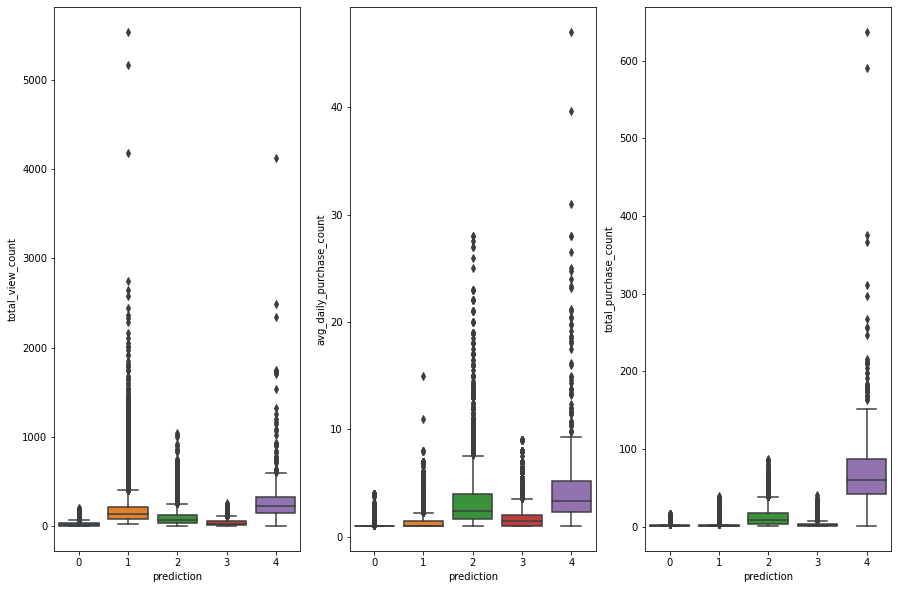

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sns.boxplot(x='prediction', y='total_view_count', data=op_df, ax=ax[0])
sns.boxplot(x='prediction', y='avg_daily_purchase_count', data=op_df, ax=ax[1])
sns.boxplot(x='prediction', y='total_purchase_count', data=op_df, ax=ax[2])

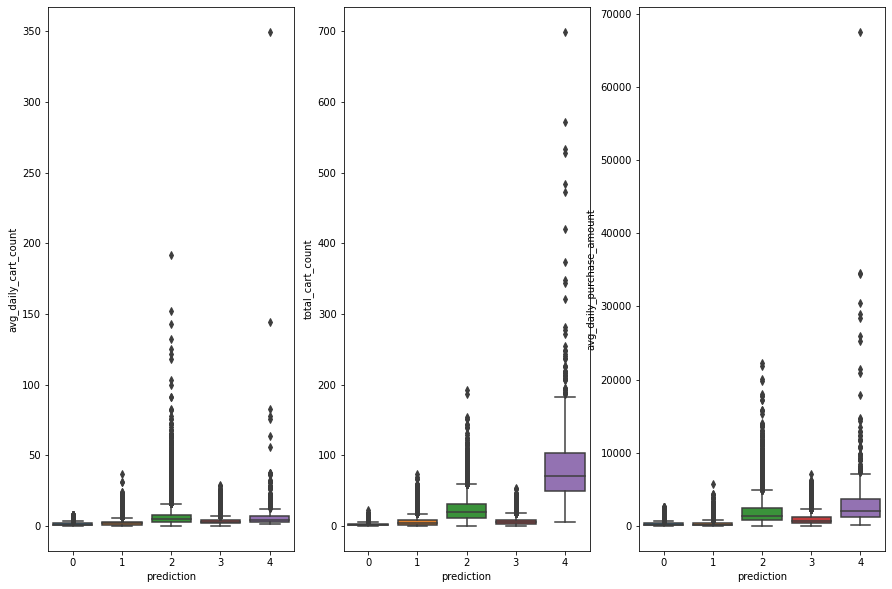

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sns.boxplot(x='prediction', y='avg_daily_cart_count', data=op_df, ax=ax[0])
sns.boxplot(x='prediction', y='total_cart_count', data=op_df, ax=ax[1])
sns.boxplot(x='prediction', y='avg_daily_purchase_amount', data=op_df, ax=ax[2])

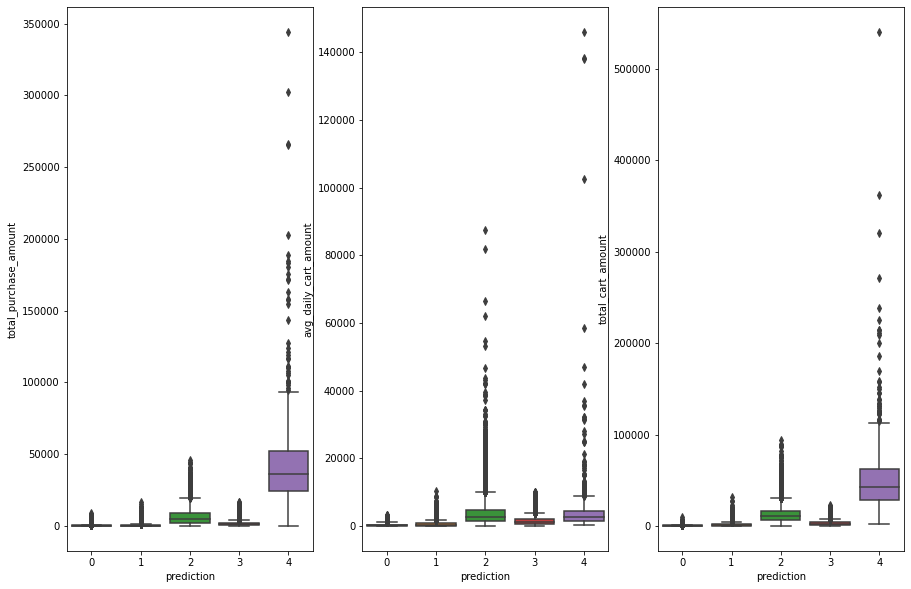

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sns.boxplot(x='prediction', y='total_purchase_amount', data=op_df, ax=ax[0])
sns.boxplot(x='prediction', y='avg_daily_cart_amount', data=op_df, ax=ax[1])
sns.boxplot(x='prediction', y='total_cart_amount', data=op_df, ax=ax[2])

In [ ]:
output.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- avg_daily_session_count: double (nullable = true)
 |-- total_session_count: long (nullable = true)
 |-- avg_daily_view_count: double (nullable = true)
 |-- total_view_count: long (nullable = true)
 |-- avg_daily_purchase_count: double (nullable = true)
 |-- total_purchase_count: long (nullable = true)
 |-- avg_daily_cart_count: double (nullable = true)
 |-- total_cart_count: long (nullable = true)
 |-- avg_daily_purchase_amount: double (nullable = true)
 |-- total_purchase_amount: double (nullable = true)
 |-- avg_daily_cart_amount: double (nullable = true)
 |-- total_cart_amount: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- standardized: vector (nullable = true)
 |-- prediction: integer (nullable = true)



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='total_purchase_count', y='total_cart_count', 
                data=op_df, 
                hue='prediction', 
                palette="deep")
plt.ylim(0, 120)
plt.xlim(0, 120)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='total_purchase_count', y='total_purchase_amount', 
                data=op_df, 
                hue='prediction', 
                palette="deep")
plt.ylim(0, 140)
plt.xlim(0, 125000)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='avg_daily_purchase_amount', y='avg_daily_session_count', 
                data=op_df, 
                hue='prediction', 
                palette="deep")
plt.ylim(0, 15000)
plt.xlim(0, 150)

NameError: ignored